In [1]:
import os
import json
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from importlib.machinery import SourceFileLoader

import shap
from baal.modelwrapper import ModelWrapper

import os, sys, torch
from pathlib import Path
from importlib.machinery import SourceFileLoader


/localdisk1/tariq/miniconda3/envs/park/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/localdisk1/tariq/miniconda3/envs/park/lib/python3.9/site-packages/torchmetrics/utilities/imports.py:23: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [2]:
ls ../../code/fusion_model/constants.py

../../code/fusion_model/constants.py


In [3]:
MODEL_DIR = Path("../../code/fusion_model").resolve()
const_path  = MODEL_DIR / "constants.py"
fusion_path = MODEL_DIR / "uncertainty_aware_fusion_wavlm.py"

# load constants first
consts = SourceFileLoader("constants", str(const_path)).load_module()

# make sure bare `import constants` works inside fusion module
sys.modules["constants"] = consts
sys.path.insert(0, str(MODEL_DIR))   # so Python can also find local imports if any

# now load fusion
fusion_mod = SourceFileLoader("uncertainty_aware_fusion_wavlm", str(fusion_path)).load_module()

# use as before
BASE_DIR          = consts.BASE_DIR
MODEL_BASE_PATH   = consts.MODEL_BASE_PATH
MODEL_CONFIG_PATH = consts.MODEL_CONFIG_PATH
MODEL_PATH        = consts.MODEL_PATH
MODEL_SUBSETS     = consts.MODEL_SUBSETS

HybridFusion = fusion_mod.HybridFusionNetworkWithUncertainty
ShallowANN   = fusion_mod.ShallowANN
ANN          = fusion_mod.ANN

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_grad_enabled(False)


Device: cuda
Length of Dev IDs 120
Length of Total Test IDs 391
Length of Validation 1 Test IDs 102
Length of Validation 2 Test IDs 90
Length of Balanced Test IDs 200
Number of patients in the dev and test set: 120, 391


In [4]:
# # 1) Point this to the folder that contains constants.py and uncertainty_aware_fusion_wavlm.py
# MODEL_DIR = Path(
#     os.environ.get("PARK_MODEL_DIR", Path.cwd() / ".." / "fusion_model")
# ).resolve()

# # 2) Sanity check
# const_path  = MODEL_DIR / "constants.py"
# fusion_path = MODEL_DIR / "uncertainty_aware_fusion_wavlm.py"
# if not const_path.exists() or not fusion_path.exists():
#     raise FileNotFoundError(f"Expected files not found in {MODEL_DIR}\n"
#                             f"- constants.py -> {const_path.exists()}\n"
#                             f"- uncertainty_aware_fusion_wavlm.py -> {fusion_path.exists()}")

# print(const_path)
# print(fusion_path)

# # 3) Load modules from absolute paths
# consts     = SourceFileLoader("consts", str(const_path)).load_module()
# fusion_mod = SourceFileLoader("fusion", str(fusion_path)).load_module()
# BASE_DIR             = consts.BASE_DIR
# MODEL_BASE_PATH      = consts.MODEL_BASE_PATH
# MODEL_CONFIG_PATH    = consts.MODEL_CONFIG_PATH
# MODEL_PATH           = consts.MODEL_PATH
# MODEL_SUBSETS        = consts.MODEL_SUBSETS

# HybridFusion = fusion_mod.HybridFusionNetworkWithUncertainty
# ShallowANN   = fusion_mod.ShallowANN
# ANN          = fusion_mod.ANN

# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# torch.set_grad_enabled(False)

# '/localdisk1/tariq/FDA Experiments/code_and_data_to_upload/code/fusion_model/constants.py'
# '/localdisk1/tariq/FDA Experiments/code_and_data_to_upload/code/fusion_model/constants.py'
# '

In [5]:
# ---------- Load fusion config & choose modalities ----------
with open(MODEL_CONFIG_PATH, "r") as f:
    cfg = json.load(f)

selected_tags = MODEL_SUBSETS[cfg["model_subset_choice"]]
fusion_mod.NUM_MODELS = len(selected_tags)
NUM_MODELS = fusion_mod.NUM_MODELS
print(f"[INFO] Modalities (order): {selected_tags}  (NUM_MODELS={NUM_MODELS})")

def _tag2name(tag: str) -> str:
    t = tag.lower()
    if "finger" in t: return "finger"
    if "fox" in t or "speech" in t: return "speech"
    if "facial" in t or "smile" in t: return "smile"
    return tag


[INFO] Modalities (order): ['finger_model_both_hand_fusion_baal', 'fox_model_best_auroc_baal', 'facial_expression_smile_best_auroc_baal']  (NUM_MODELS=3)


In [6]:
# ---------- Build fusion dataframe exactly like training ----------
def build_fusion_df():
    model_paths = []
    for MODEL_TAG in selected_tags:
        model_paths.append({
            "TAG": MODEL_TAG,
            "PREDICTOR_CONFIG": os.path.join(MODEL_BASE_PATH, MODEL_TAG, "predictive_model", "model_config.json"),
            "PREDICTOR_MODEL":  os.path.join(MODEL_BASE_PATH, MODEL_TAG, "predictive_model", "model.pth"),
            "SCALER_PKL":       os.path.join(MODEL_BASE_PATH, MODEL_TAG, "scaler", "scaler.pkl"),
            "SCALER_PTH":       os.path.join(MODEL_BASE_PATH, MODEL_TAG, "scaler", "scaler.pth"),
        })

    merged = None
    for i, paths in enumerate(model_paths):
        with open(paths["PREDICTOR_CONFIG"], "r") as f:
            pc = json.load(f)
        drop_corr = (pc.get("drop_correlated", "yes") == "yes")
        corr_thr  = pc.get("corr_thr", 0.85)

        if "finger_model" in paths["TAG"]:
            fr, lr, idr, _, rid_r = fusion_mod.load_finger_data(hand="right", drop_correlated=drop_corr, corr_thr=corr_thr)
            fl, ll, idl, _, rid_l = fusion_mod.load_finger_data(hand="left",  drop_correlated=drop_corr, corr_thr=corr_thr)
            dfr  = pd.DataFrame({"features_right": list(fr), "id_right": idr, "row_id": rid_r, "label_right": lr})
            dfl  = pd.DataFrame({"features_left":  list(fl), "id_left":  idl, "row_id": rid_l, "label_left":  ll})
            both = dfr.merge(dfl, on="row_id", how="inner") \
                      .drop(columns=["label_left","id_left"]) \
                      .rename(columns={"label_right":"label", "id_right":"id"})
            both["features"] = both.apply(fusion_mod.concat_finger_features, axis=1)
            features = np.stack(both["features"].to_numpy())
            labels   = both["label"].to_numpy()
            ids      = both["id"].to_numpy()
            row_ids  = both["row_id"].to_numpy()
        elif "fox_model" in paths["TAG"]:
            features, labels, ids, _, row_ids = fusion_mod.load_qbf_data(drop_correlated=drop_corr, corr_thr=corr_thr)
        elif "facial_expression_smile" in paths["TAG"]:
            features, labels, ids, _, row_ids = fusion_mod.load_smile_data(drop_correlated=drop_corr, corr_thr=corr_thr)
        else:
            raise RuntimeError(f"Unknown model tag: {paths['TAG']}")

        scaler = None
        if pc.get("use_feature_scaling","no") == "yes":
            if os.path.exists(paths["SCALER_PKL"]):
                scaler = pickle.load(open(paths["SCALER_PKL"], "rb"))
            elif os.path.exists(paths["SCALER_PTH"]):
                scaler = pickle.load(open(paths["SCALER_PTH"], "rb"))
            if scaler is not None:
                features = scaler.transform(features)

        block = pd.DataFrame({
            f"features_{i}": list(features),
            f"label_{i}":    labels,
            f"id_{i}":       ids,
            "row_id":        row_ids
        })
        if merged is None:
            merged = block
        else:
            merged = merged.merge(block, on="row_id", how="inner") \
                           .drop(columns=[f"label_{i}", f"id_{i}"])

    df = merged.rename(columns={"label_0":"label","id_0":"id"})
    print(f"[INFO] Fusion df: {df.shape}, columns={list(df.columns)}")
    return df, model_paths

fusion_df, model_paths = build_fusion_df()
feature_shapes = [len(fusion_df.iloc[0][f"features_{i}"]) for i in range(NUM_MODELS)]
modality_names = [_tag2name(t) for t in selected_tags]


---------------------- Data for right hand finger tapping is loaded ----------------------
---------------------- -------------- ----------------------
116
---------------------- -------------- ----------------------
---------------------- Data for left hand finger tapping is loaded ----------------------
---------------------- -------------- ----------------------
116
---------------------- -------------- ----------------------
---------------------- Data for speech is loaded ----------------------
---------------------- -------------- ----------------------
1024
---------------------- -------------- ----------------------
---------------------- Data for smile is loaded ----------------------
---------------------- -------------- ----------------------
42
---------------------- -------------- ----------------------
[INFO] Fusion df: (1119, 6), columns=['features_0', 'label', 'id', 'row_id', 'features_1', 'features_2']


/localdisk1/tariq/FDA Experiments/code_and_data_to_upload/code/fusion_model/uncertainty_aware_fusion_wavlm.py:187: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(FEATURES_FILE)
/localdisk1/tariq/FDA Experiments/code_and_data_to_upload/code/fusion_model/uncertainty_aware_fusion_wavlm.py:244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["id"] = df.Filename.apply(parse_patient_id)
/localdisk1/tariq/FDA Experiments/code_and_data_to_upload/code/fusion_model/uncertainty_aware_fusion_wavlm.py:245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [7]:
# ---------- Load frozen unimodal predictors exactly like training ----------
def load_unimodal_models():
    models = []
    for i, paths in enumerate(model_paths):
        with open(paths["PREDICTOR_CONFIG"], "r") as f:
            pc = json.load(f)
        drop_prob  = pc["dropout_prob"]
        model_type = pc.get("model","ANN")
        if model_type == "ShallowANN":
            mdl = ShallowANN(feature_shapes[i], drop_prob=drop_prob)
            mdl.load_state_dict(torch.load(paths["PREDICTOR_MODEL"], map_location=DEVICE))
            mdl = mdl.to(DEVICE).eval()
            mdl.fc.weight.requires_grad = False
            mdl.fc.bias.requires_grad = False
        else:
            mdl = ANN(feature_shapes[i], drop_prob=drop_prob)
            mdl.load_state_dict(torch.load(paths["PREDICTOR_MODEL"], map_location=DEVICE))
            mdl = mdl.to(DEVICE).eval()
            mdl.fc1.weight.requires_grad = False
            mdl.fc1.bias.requires_grad   = False
            mdl.fc2.weight.requires_grad = False
            mdl.fc2.bias.requires_grad   = False
        models.append(mdl)
    print("[INFO] Unimodal predictors loaded.")
    return models

unimodal_models = load_unimodal_models()

[INFO] Unimodal predictors loaded.


In [8]:
# ---------- Compute unimodal MC-dropout means/vars ----------
def predict_unimodal_scores_and_vars(df, num_trials):
    wrappers = [ModelWrapper(m, nn.BCELoss()) for m in unimodal_models]
    scores = {}
    vars_  = {}
    X_mods = [np.stack(df[f"features_{i}"].to_numpy()) for i in range(NUM_MODELS)]
    for i, name in enumerate(modality_names):
        X = torch.from_numpy(X_mods[i]).float().to(DEVICE)
        y_multi = wrappers[i].predict_on_batch(X, iterations=num_trials)  # [B, T]
        y_multi = y_multi.detach().cpu().numpy() if hasattr(y_multi, "detach") else np.asarray(y_multi)
        scores[name] = y_multi.mean(axis=-1).astype(np.float32)  # [B]
        vars_[name]  = y_multi.std(axis=-1).astype(np.float32)   # [B]
        print(f"[INFO] {name}: computed {len(scores[name])} scores/vars (T={num_trials}).")
    return scores, vars_

num_trials = int(cfg.get("num_trials", 30))
unimodal_scores, unimodal_vars = predict_unimodal_scores_and_vars(fusion_df, num_trials)


[INFO] finger: computed 1119 scores/vars (T=30).
[INFO] speech: computed 1119 scores/vars (T=30).
[INFO] smile: computed 1119 scores/vars (T=30).


In [9]:
# ---------- Build flat matrix (features + preds + vars) ----------
def _to_1d(x):
    a = np.asarray(x)
    if a.ndim == 1: return a
    a = np.squeeze(a)
    if a.ndim == 1: return a
    b_ax = int(np.argmax(a.shape))  # keep batch axis, average others
    axes = tuple(ax for ax in range(a.ndim) if ax != b_ax)
    return a.mean(axis=axes)

for name in modality_names:
    unimodal_scores[name] = _to_1d(unimodal_scores[name]).astype(np.float32)
    unimodal_vars[name]   = _to_1d(unimodal_vars[name]).astype(np.float32)

feat_slices = []
start = 0
for d in feature_shapes:
    feat_slices.append(slice(start, start + d))
    start += d
pred_slice = slice(start, start + len(modality_names)); start += len(modality_names)
var_slice  = slice(start, start + len(modality_names)); start += len(modality_names)
TOTAL_D    = start

def build_flat_matrix_features_preds_vars(df):
    feats_per_mod  = [np.stack(df[f"features_{i}"].to_numpy()).astype(np.float32)
                      for i in range(len(modality_names))]
    features_block = np.concatenate(feats_per_mod, axis=1)  # [B, sum(d_i)]
    preds_block = np.column_stack([unimodal_scores[name] for name in modality_names]).astype(np.float32)  # [B, K]
    vars_block  = np.column_stack([unimodal_vars[name]   for name in modality_names]).astype(np.float32)  # [B, K]
    B = features_block.shape[0]
    assert preds_block.shape == (B, len(modality_names))
    assert vars_block.shape  == (B, len(modality_names))
    return np.concatenate([features_block, preds_block, vars_block], axis=1)

X_all = build_flat_matrix_features_preds_vars(fusion_df)
y_all = fusion_df["label"].astype(int).to_numpy()

feature_names = []
for i, name in enumerate(modality_names):
    feature_names += [f"{name}_{j}" for j in range(feature_shapes[i])]
feature_names += [f"pred_{name}" for name in modality_names]
feature_names += [f"var_{name}"  for name in modality_names]

print(f"[INFO] X_all: {X_all.shape}  (features={sum(feature_shapes)}, preds+vars={2*len(modality_names)}, TOTAL_D={TOTAL_D})")


[INFO] X_all: (1119, 1304)  (features=1298, preds+vars=6, TOTAL_D=1304)


In [10]:
# ---------- Load fusion model & make it deterministic ----------
fusion_model = HybridFusion(feature_shapes, cfg).to(DEVICE)
fusion_model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
fusion_model.eval()

def disable_mc_dropout(module: torch.nn.Module):
    for m in module.modules():
        if m.__class__.__module__.startswith("baal") and m.__class__.__name__.lower().endswith("dropout"):
            if hasattr(m, "p"): m.p = 0.0
            m.training = False
        if isinstance(m, torch.nn.Dropout):
            m.p = 0.0
            m.training = False

disable_mc_dropout(fusion_model)

In [11]:
import numpy as np
import torch
import torch.nn as nn

class FusionWrapper(nn.Module):
    """
    X layout (src order):
      [ features_0 | ... | features_{K-1} | preds (K) | vars (K) ]

    Calls the model with ONE arg:
      (features_list, preds_list, vars_list)
      - features_list : list of [N, d_i] tensors (model order)
      - preds_list    : list of [N] tensors (model order)
      - vars_list     : list of [N] tensors (model order)
    """
    def __init__(self,
                 fusion_model,
                 feat_slices,            # per-modality feature slices in X (src order)
                 pred_slice,             # slice for preds in X
                 var_slice,              # slice for vars  in X
                 src_modality_names,     # e.g. ["finger","speech","smile"] in X order
                 model_selected_tags,    # tags used to build the model (model order)
                 device,
                 default_pred: float = 0.5,
                 default_var: float = 0.0):
        super().__init__()
        self.m = fusion_model.eval()
        self.device = device
        self.feat_slices = list(feat_slices)
        self.pred_slice  = pred_slice
        self.var_slice   = var_slice
        self.src_names   = list(src_modality_names)
        self.default_pred = float(default_pred)
        self.default_var  = float(default_var)

        def _tag2name(tag: str) -> str:
            t = str(tag).lower()
            if "finger" in t: return "finger"
            if "fox" in t or "speech" in t: return "speech"
            if "facial" in t or "smile"  in t: return "smile"
            return t

        # Model’s expected modality order
        self.model_names = [_tag2name(t) for t in model_selected_tags]

        # Map: model order -> indices in X (src order)
        self.src_idx_for_model = [self.src_names.index(nm) for nm in self.model_names]

        # Feature slices reordered to model order
        self.ordered_feat_slices = [self.feat_slices[i] for i in self.src_idx_for_model]

    def forward(self, x_np):
        # Accept (D,) or (N,D); return (N,)
        x = torch.from_numpy(np.asarray(x_np)).float()
        if x.ndim == 1:
            x = x.unsqueeze(0)
        x = x.to(self.device)
        N = x.shape[0]
        K = len(self.ordered_feat_slices)

        # 1) features_list: list of [N, d_i] (model order)
        features_list = [x[:, sl] for sl in self.ordered_feat_slices]

        # 2) preds_list: list of [N] (model order)
        if self.pred_slice is None:
            preds_mat = torch.full((N, K), self.default_pred, dtype=x.dtype, device=x.device)
        else:
            preds_src = x[:, self.pred_slice]            # [N, K_src] or [N]
            if preds_src.ndim == 1:
                preds_src = preds_src.view(N, -1)
            preds_mat = preds_src[:, self.src_idx_for_model]   # [N, K] model order
        preds_list = [preds_mat[:, i].reshape(N).contiguous() for i in range(K)]

        # 3) vars_list: list of [N] (model order)
        if self.var_slice is None:
            vars_mat = torch.full((N, K), self.default_var, dtype=x.dtype, device=x.device)
        else:
            vars_src = x[:, self.var_slice]              # [N, K_src] or [N]
            if vars_src.ndim == 1:
                vars_src = vars_src.view(N, -1)
            vars_mat = vars_src[:, self.src_idx_for_model]     # [N, K] model order
        vars_list = [vars_mat[:, i].reshape(N).contiguous() for i in range(K)]

        # 4) Single 3-tuple call → model will torch.stack(...).transpose(0,1) internally
        out = self.m((features_list, preds_list, vars_list))
        return out.reshape(-1).detach().cpu().numpy()


In [12]:
wrapped = FusionWrapper(
    fusion_model=fusion_model,
    feat_slices=feat_slices,
    pred_slice=pred_slice,
    var_slice=var_slice,
    src_modality_names=modality_names,   # X order
    model_selected_tags=selected_tags,   # model's expected order
    device=DEVICE
).eval()

In [13]:

# ====================== SHAP: Train background, Test evaluation ======================

test_ids = [ln.strip() for ln in open("../../data/test_set_participants.txt")]
assert "id" in fusion_df.columns, "fusion_df must have an 'id' column."

# ---- 1) Build row masks: test = ids in test_ids; train = not in test ----
# (Per-row SHAP. If you want 1 row per participant, dedupe here before masking.)
id_series = fusion_df["id"]
test_mask  = id_series.isin(test_ids).to_numpy()
train_mask = ~test_mask

idx_test  = np.flatnonzero(test_mask)
idx_train = np.flatnonzero(train_mask)

X_train, y_train = X_all[idx_train], y_all[idx_train]
X_test,  y_test  = X_all[idx_test],  y_all[idx_test]

print(f"[INFO] Rows — train: {len(X_train)}, test: {len(X_test)}  (features D={X_all.shape[1]})")



[INFO] Rows — train: 799, test: 320  (features D=1304)


In [14]:
# # ---- 2) Background from TRAIN distribution (k-means summary) ----
# k_bg = int(np.clip(0.4 * len(X_train), 100, 300))  # ~40% of train, clamped to [100,300]
# X_bg = shap.kmeans(X_train, k_bg)
# print(f"[INFO] Background (train k-means): k={k_bg}, shape={np.asarray(X_bg).shape}")

# # ---- 3) SHAP explainer on TEST set (model on GPU; Kernel math is CPU) ----
# expl = shap.KernelExplainer(lambda A: wrapped.forward(A), X_bg, link="logit")
# nsamp  = 1500
# l1_reg = "num_features(64)"
# print(f"[INFO] Explaining TEST: nsamples={nsamp}, l1_reg={l1_reg}")

# try:
#     shap_vals_test = expl.shap_values(X_test, nsamples=nsamp, l1_reg=l1_reg)  # (n_test, D)
#     expected_value_test = expl.expected_value
# except Exception as e:
#     print("[WARN] KernelExplainer failed; falling back to SamplingExplainer:", e)
#     expl = shap.SamplingExplainer(lambda A: wrapped.forward(A), X_bg)
#     shap_vals_test = expl.shap_values(X_test, nsamples=nsamp)
#     expected_value_test = expl.expected_value

# shap_vals_test = np.asarray(shap_vals_test)
# print("[INFO] Test SHAP done:", shap_vals_test.shape, "expected_value:", expected_value_test)

# # (Optional) guard against any non-finite values before plotting (do not modify for stats)
# if not np.isfinite(shap_vals_test).all():
#     finite = np.isfinite(shap_vals_test)
#     q = np.quantile(np.abs(shap_vals_test[finite]), 0.995)
#     shap_vals_plot = np.clip(shap_vals_test, -q, q)
#     print(f"[INFO] Clipped for plotting at ±{q:.4g}.")
# else:
#     shap_vals_plot = shap_vals_test

# # ---- 4) (Optional) Modality totals on TEST: include features + pred + var (sum |SHAP|) ----
# def slice_indices(slc: slice): 
#     return np.arange(slc.start, slc.stop)

# abs_vals_t = np.abs(shap_vals_test)
# mean_abs_t = abs_vals_t.mean(axis=0)
# pred_cols = slice_indices(pred_slice)
# var_cols  = slice_indices(var_slice)

# rows = []
# for i, mod in enumerate(modality_names):
#     feat_sum = float(mean_abs_t[feat_slices[i]].sum())
#     pred_val = float(mean_abs_t[pred_cols[i]])
#     var_val  = float(mean_abs_t[var_cols[i]])
#     total    = feat_sum + pred_val + var_val
#     rows.append({"modality": mod, "features_sum": feat_sum, "pred": pred_val, "var": var_val, "total": total})

# mod_totals_test = pd.DataFrame(rows)
# mod_totals_test["percent"] = 100 * mod_totals_test["total"] / mod_totals_test["total"].sum()
# print("\n[INFO] TEST modality totals (sum |SHAP| incl. preds/vars):")
# print(mod_totals_test.round(3))
# print("Check % sum:", round(mod_totals_test["percent"].sum(), 3))

# # ---- 5) (Optional) Top-k features per modality on TEST (feature dims only) ----
# def topk_features_for_mod_test(mod_name: str, k: int = 15):
#     i = modality_names.index(mod_name)
#     sl = feat_slices[i]
#     vals = mean_abs_t[sl]
#     order = np.argsort(vals)[::-1][:k]
#     names = [f"{mod_name}_{j}" for j in order]
#     return pd.DataFrame({"feature": names, "mean_abs_shap": vals[order]})

# # Example printouts
# print("\n[INFO] Top-10 finger features (TEST):")
# print(topk_features_for_mod_test("finger", 10).round(6))
# print("\n[INFO] Top-10 smile features (TEST):")
# print(topk_features_for_mod_test("smile", 10).round(6))
# print("\n[INFO] Top-10 speech features (TEST):")
# print(topk_features_for_mod_test("speech", 10).round(6))

In [15]:
# # ---- 6) Save everything AS-IS via pickle ----
# OUT_DIR = os.path.join(BASE_DIR, "shap_outputs")
# os.makedirs(OUT_DIR, exist_ok=True)
# dump_path = os.path.join(OUT_DIR, "shap_raw_test_trainbg.pkl")

# with open(dump_path, "wb") as f:
#     pickle.dump(
#         # store exactly what you'd want to reload
#         (shap_vals_test, idx_test, expected_value_test, feature_names, X_test, nsamp, k_bg, l1_reg),
#         f,
#         protocol=pickle.HIGHEST_PROTOCOL
#     )

# print(f"[INFO] Pickled test SHAP (train background) to {dump_path}")

In [16]:
import pickle, os
OUT_DIR = os.path.join("shap_outputs")
dump_path = os.path.join(OUT_DIR, "shap_raw_test_trainbg.pkl")
with open(dump_path, "rb") as f:
    shap_vals_test, idx_test, expected_value_test, feature_names, X_test, nsamp, k_bg, l1_reg = pickle.load(f)



In [17]:
# let's read the raw feature datasets to see the column names
DATA_DIR = os.path.join(BASE_DIR, "data")
finger_data_dir = os.path.join(DATA_DIR, "finger_tapping/data_finger_tapping.csv")
df_finger= pd.read_csv(finger_data_dir)
non_feature_columns = [
 'Unnamed: 0',
 'filename',
 'Participant_ID',
 'date',
 'hand',
 'pd',
 'Protocol',
 'Task',
 'Duration',
 'FPS',
 'Frame_Height',
 'Frame_Width',
 'gender',
 'age',
 'race',
 'ethnicity',
 'dob',
 'time_mdsupdrs'
]
finger_feature_names = df_finger.columns.drop(non_feature_columns).to_list()
finger_feature_names_map = {}
i = 0
hand = 'right'
for column in finger_feature_names:
    finger_feature_names_map[f'finger_{i}'] = f'{hand}_{column}'
    i += 1 
    
hand = 'left'
for column in finger_feature_names:
    finger_feature_names_map[f'finger_{i}'] = f'{hand}_{column}'
    i += 1  

# let's read the raw feature datasets to see the column names
DATA_DIR = os.path.join(BASE_DIR, "data")
smile_data_dir = os.path.join(DATA_DIR, "facial_expression_smile/data_smile.csv")
df_smile= pd.read_csv(smile_data_dir)
df_smile.columns
non_feature_columns = [
'ID', 'date', 'pd', 'Diagnosis', 'Filename', 'Protocol', 'Participant_ID', 'Task',
       'age', 'race', 'ethnicity', 'Filename_core'
]
smile_feature_names = df_smile.columns.drop(non_feature_columns).to_list()
smile_feature_names_map = {}
i = 0
for column in smile_feature_names:
    smile_feature_names_map[f'smile_{i}'] = column
    i += 1  
    

speech_feature_names_map = {}
for i in range(1024):
    speech_feature_names_map[f'speech_{i}'] = f'WavLM_feature_{i}'
    i += 1  

feature_maps = {
    'finger': finger_feature_names_map,
    'speech': speech_feature_names_map,
    'smile': smile_feature_names_map
}

In [18]:

# ---- 4) (Optional) Modality totals on TEST: include features + pred + var (sum |SHAP|) ----
def slice_indices(slc: slice): 
    return np.arange(slc.start, slc.stop)

abs_vals_t = np.abs(shap_vals_test)
mean_abs_t = abs_vals_t.mean(axis=0)
pred_cols = slice_indices(pred_slice)
var_cols  = slice_indices(var_slice)

rows = []
for i, mod in enumerate(modality_names):
    feat_sum = float(mean_abs_t[feat_slices[i]].sum())
    pred_val = float(mean_abs_t[pred_cols[i]])
    var_val  = float(mean_abs_t[var_cols[i]])
    total    = feat_sum + pred_val + var_val
    rows.append({"modality": mod, "features_sum": feat_sum, "pred": pred_val, "var": var_val, "total": total})

mod_totals_test = pd.DataFrame(rows)
mod_totals_test["percent"] = 100 * mod_totals_test["total"] / mod_totals_test["total"].sum()
print("\n[INFO] TEST modality totals (sum |SHAP| incl. preds/vars):")
print(mod_totals_test.round(3))
print("Check % sum:", round(mod_totals_test["percent"].sum(), 3))


# ---- 5) (Optional) Top-k features per modality on TEST (feature dims only) ----
def topk_features_for_mod_test(mod_name: str, k: int = 15):
    i = modality_names.index(mod_name)
    sl = feat_slices[i]
    vals = mean_abs_t[sl]
    order = np.argsort(vals)[::-1][:k]
    names = [f"{mod_name}_{j}" for j in order]
    names = [feature_maps[mod_name][name] for name in names]
    return pd.DataFrame({"feature": names, "mean_abs_shap": vals[order]})

# Example printouts
print("\n[INFO] Top-10 finger features (TEST):")
print(topk_features_for_mod_test("finger", 10).round(6))
print("\n[INFO] Top-10 smile features (TEST):")
print(topk_features_for_mod_test("smile", 10).round(6))
print("\n[INFO] Top-10 speech features (TEST):")
print(topk_features_for_mod_test("speech", 10).round(6))


[INFO] TEST modality totals (sum |SHAP| incl. preds/vars):
  modality  features_sum   pred    var  total  percent
0   finger         0.354  1.072  0.019  1.445   21.152
1   speech         0.905  1.570  0.054  2.529   37.005
2    smile         2.575  0.230  0.054  2.859   41.843
Check % sum: 100.0

[INFO] Top-10 finger features (TEST):
                                         feature  mean_abs_shap
0  right_amplitude_decrement_fitness_r2_denoised       0.007553
1                   right_frequency_min_denoised       0.005928
2                    right_aperiodicity_denoised       0.005905
3                     left_aperiodicity_denoised       0.004749
4                 right_frequency_median_trimmed       0.004274
5                     left_frequency_min_trimmed       0.004120
6                        left_period_min_trimmed       0.004025
7                       left_period_min_denoised       0.003835
8   left_amplitude_decrement_fitness_r2_denoised       0.003786
9                     

/localdisk1/tariq/miniconda3/envs/park/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/localdisk1/tariq/miniconda3/envs/park/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


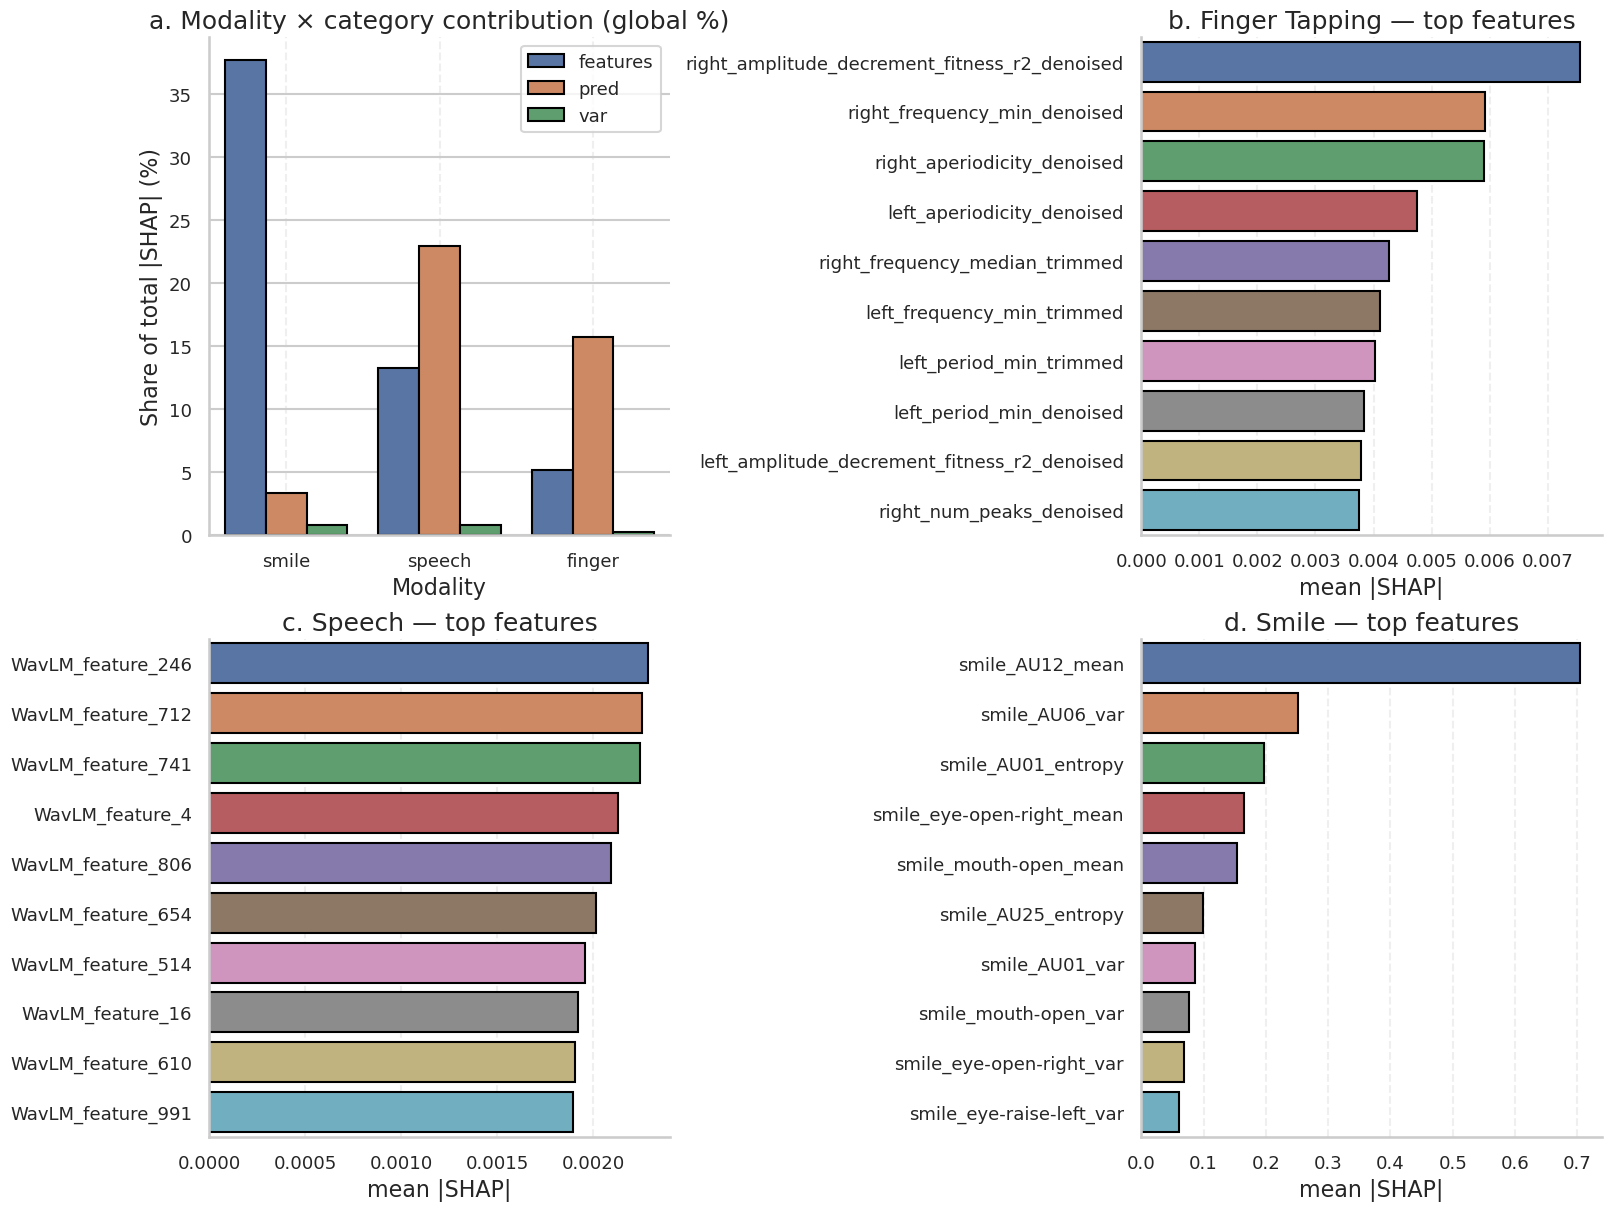

[INFO] Saved SHAP figure panels to:
  shap_outputs/fig_shap_panels.png
  shap_outputs/fig_shap_panels.pdf


In [19]:
# ===================== SHAP – 4-panel figure (seaborn) =====================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Inputs assumed present from your pipeline ---
# shap_vals_test: (n_test, D)
# mean_abs_t     : (D,) = np.abs(shap_vals_test).mean(axis=0)
# modality_names : e.g., ["finger","speech","smile"]
# feat_slices    : list[slice], per modality feature block
# pred_slice     : slice (length K)
# var_slice      : slice (length K)
# mod_totals_test: DataFrame from your snippet (modality, features_sum, pred, var, total, percent)
# feature_maps   : optional dict mapping raw feature names -> pretty labels per modality

# ---------------- helpers ----------------
def slice_indices(slc: slice): 
    return np.arange(slc.start, slc.stop)

def topk_features_for_mod_test(mod_name: str, k: int = 10):
    """Return top-k feature rows (pretty-labeled if feature_maps is present)."""
    i = modality_names.index(mod_name)
    sl  = feat_slices[i]
    vals = mean_abs_t[sl]
    order = np.argsort(vals)[::-1][:k]
    raw_names = [f"{mod_name}_{j}" for j in order]
    # pretty labels if available
    if "feature_maps" in globals() and isinstance(feature_maps, dict) and mod_name in feature_maps:
        fmap = feature_maps[mod_name]
        names = [fmap.get(n, n) for n in raw_names]
    else:
        names = raw_names
    return pd.DataFrame({"feature": names, "mean_abs_shap": vals[order]})

def annotate_bars(ax, fmt="{:.1f}%"):
    for p in ax.patches:
        h = p.get_height()
        if h <= 0: 
            continue
        ax.annotate(fmt.format(h),
                    (p.get_x() + p.get_width()/2., h),
                    ha="center", va="bottom", fontsize=11, rotation=0,
                    xytext=(0, 2), textcoords="offset points")

# ---------------- panel (a): modality × category (global %) ----------------
# Build 9-component table: features_sum / pred / var for each modality, as % of total across all 9.
comp = mod_totals_test.melt(id_vars=["modality"],
                            value_vars=["features_sum","pred","var"],
                            var_name="component", value_name="value")
comp["component"] = comp["component"].replace({
    "features_sum":"features", "pred":"pred", "var":"var"
})
# keep canonical modality order for plotting
comp["modality"] = pd.Categorical(comp["modality"], categories=modality_names, ordered=True)

# global normalization (sum over all 9 = 100%)
comp["percent_global"] = 100 * comp["value"] / comp["value"].sum()

# Order modalities by total impact (sum of features + pred + var), high → low
mod_order = (mod_totals_test
             .sort_values("total", ascending=False)["modality"]
             .tolist())

# Set categorical order and reuse in the barplot call
comp["modality"] = pd.Categorical(comp["modality"], categories=mod_order, ordered=True)


# ---------------- panel (b–d): top features per modality ----------------
TOPK = 10
df_finger = topk_features_for_mod_test("finger", TOPK).sort_values("mean_abs_shap", ascending=True)
df_speech = topk_features_for_mod_test("speech", TOPK).sort_values("mean_abs_shap", ascending=True)
df_smile  = topk_features_for_mod_test("smile",  TOPK).sort_values("mean_abs_shap",  ascending=True)

# ---------------- styling ----------------
sns.set_theme(context="talk", style="whitegrid")      # larger base fonts
plt.rcParams.update({
    "axes.titlesize": 18,
    "axes.labelsize": 16,
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "legend.fontsize": 13
})

# ---------------- plot ----------------
fig, axs = plt.subplots(2, 2, figsize=(16, 12), constrained_layout=True)

# (a) Modality × category (stacked percentages per modality OR grouped)
# We'll do grouped bars (easier to compare categories per modality)
ax = axs[0,0]
sns.barplot(
    data=comp, x="modality", y="percent_global", hue="component",
    order=mod_order,                 # <— add this
    ax=ax, edgecolor="black"
)

ax.set_xlabel("Modality")
ax.set_ylabel("Share of total |SHAP| (%)")
ax.set_title("a. Modality × category contribution (global %)")
ax.legend(title="", loc="upper right", frameon=True)

# (b) Top-k finger (horizontal)
ax = axs[0,1]
sns.barplot(
    data=df_finger.iloc[::-1],    # reverse so largest at top
    x="mean_abs_shap", y="feature",
    ax=ax, edgecolor="black"
)
ax.set_title("b. Finger Tapping — top features")
ax.set_xlabel("mean |SHAP|")
ax.set_ylabel("")

# (c) Top-k speech (horizontal)
ax = axs[1,0]
sns.barplot(
    data=df_speech.iloc[::-1],
    x="mean_abs_shap", y="feature",
    ax=ax, edgecolor="black"
)
ax.set_title("c. Speech — top features")
ax.set_xlabel("mean |SHAP|")
ax.set_ylabel("")

# (d) Top-k smile (horizontal)
ax = axs[1,1]
sns.barplot(
    data=df_smile.iloc[::-1],
    x="mean_abs_shap", y="feature",
    ax=ax, edgecolor="black"
)
ax.set_title("d. Smile — top features")
ax.set_xlabel("mean |SHAP|")
ax.set_ylabel("")

# tidy up grids and spines a bit
for ax in axs.ravel():
    ax.grid(axis="x", linestyle="--", alpha=0.3)
    for spine in ["top","right"]:
        ax.spines[spine].set_visible(False)

# save
OUT_DIR = os.path.join("shap_outputs")
os.makedirs(OUT_DIR, exist_ok=True)
png_path = os.path.join(OUT_DIR, "fig_shap_panels.png")
pdf_path = os.path.join(OUT_DIR, "fig_shap_panels.pdf")
plt.savefig(png_path, dpi=300, bbox_inches="tight")
plt.savefig(pdf_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"[INFO] Saved SHAP figure panels to:\n  {png_path}\n  {pdf_path}")
